# Fragment calculation for a water dimer
The aim of this lesson is to present how to do basic fragment calculations with BigDFT and explain how to do to basic calculations. It is recommended that you have read the relevant papers in articles describing BigDFT and go through the tutorials on linear-scaling BigDFT before beginning.

## Template calculation

<img src="http://bigdft.org/images/1/19/H2o_dimer.png">
We consider the example of a water dimer with varying separation R between the molecules. Since we have two identical water molecules, they can both be represented by the same template fragment. The first step is therefore to generate the support functions for an isolated water molecule. We will use the following h2o.xyz and h2o.yaml input files: 

In [1]:
h2o_xyz = """\
3 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371"""

input_yaml = """\
 import: linear
 dft:
   hgrids: {hgrids}
   rmult: [5.0, 7.0]
   inputpsiid: linear
   ixc: LDA (ABINIT)
 lin_general:
   output_wf: 1
   output_mat: 11
 lin_kernel:
   alphamix: 0.3
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
"""

Note the non-zero values for output_wf and output_mat, which specify that the support functions and associated matrices be written to file. You should also observe that we have chosen a rather small value for hgrid, which will ensure a more accurate interpolation when the support functions are roto-translated.

Fragment calculations require the template information to be in a sub-directory, so you should proceed to run BigDFT in the following manner: 

In [2]:
import os,sys,commands,shutil
BigDFT = os.environ["BIGDFT_ROOT"]+"/bigdft"
os.environ["OMP_NUM_THREADS"]="4" #depends on your computer (compiled with OpenMP)

def run_bigdft(prefix,yaml,xyz):
    if not os.path.exists("log-"+prefix+".yaml"):
        open(prefix+".yaml","w").write(yaml)
        open(prefix+".xyz","w").write(xyz)
        sys.stdout.write(prefix + " ... ")
        sys.stdout.flush()
        output = commands.getstatusoutput("%s --name=%s" % (BigDFT,prefix))
        sys.stdout.write(str(output) + "\n")
    else:
        print "Logfile log-%s.yaml does already exist!" % prefix
        
#Extract the archive if it exists to avoid running all calculations
tarname = 'log-h2o-dissociation.tgz'
if os.path.exists(tarname):
    print "The tar file %s with all log files exists: we use it avoiding calculations!" % tarname
    import tarfile
    tar = tarfile.open(tarname,"r:bz2")
    #for n in tar.getmembers(): 
    #    print n.name
    tar.extractall()
    tar.close()

tartemplate = "h2o-templates.tgz"
if os.path.exists(tartemplate):
    #print "The tar file %s with all log files exists: we use it avoiding calculations!" % tarname
    tar = tarfile.open(tartemplate,"r:bz2")
    tar.extractall()
    tar.close()

#Run the template of the H2O molecule
run_bigdft(prefix="h2o",yaml=input_yaml.format(hgrids="0.25",Hn="1",On="4"),xyz=h2o_xyz)

Logfile log-h2o.yaml does already exist!


At the end of the calculation, you will notice that another directory data-h2o been created by BigDFT, which contains a number of files for the support functions and matrices. With these outputs, we can proceed to do a fragment calculation. 

## Fragment calculations
We will consider three different scenarios for the dimer: 
* with the molecules at a short separation, 
* close to the equilibrium, and 
* far apart.

Note that in each case, we keep the molecules rigid, with neither the isolated or dimer system in a fully relaxed state, as this is only intended to serve as a model system. We therefore have three position inputs: dimer_1.5.xyz, dimer_2.0.xyz and dimer_5.0.xyz: 

In [3]:
def dimer_xyz(d):
    x1 = d
    x2 = d + 0.296831000000
    x3 = d + 0.273536000000
    d_xyz = """\
6 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             {0:14.12f}           -0.003706000000            0.113495000000
H             {1:14.12f}            0.762122000000           -0.351887000000
H             {2:14.12f}           -0.747744000000           -0.399151000000"""
    return d_xyz.format(x1,x2,x3)

dists = [1.5,2.0,5.0]
print dimer_xyz(1.5)

6 angstroemd0
free
O            -0.931477999671            0.004547999723           -0.117331000086
H            -1.355753693973           -0.032108553467            0.725181911626
H            -0.003078395366            0.011003111969            0.053703839371
O             1.500000000000           -0.003706000000            0.113495000000
H             1.796831000000            0.762122000000           -0.351887000000
H             1.773536000000           -0.747744000000           -0.399151000000


We of course also need a *dimer.yaml* input file: 

In [4]:
dimer_yaml = """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   inputpsiid: linear_restart
   ixc: LDA (ABINIT)
 lin_general:
   nit: 1
   kernel_restart_mode: kernel
 lin_basis:
   nit: 1
 lin_kernel:
   nit: [20,100]
   alphamix: 0.3
   rpnrm_cv: 1.0E-010
   linear_method: FOE
 lin_basis_params:
   O:
     nbasis: {On}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
   H:
     nbasis: {Hn}
     ao_confinement: 1.0E-002
     confinement: [5.0E-003, 0.0]
     rloc: 9.0
     rloc_kernel: 12.0
     rloc_kernel_foe: 14.0
"""

frag_yaml = """\
 frag:
   h2o: [1, 2]
"""

Compared to a standard linear-scaling calculation, there are not many big changes to the input. You will of course notice that we have specified that this is a restart calculation via the *inputpsiid* variable, and we have allowed for a large number of kernel iterations while **eliminating basis optimization by setting _nit_ to 1** in the *lin_basis* block.

Most importantly, we have also **added a frag block**, which is where we we specify the number of fragments and their types. In this example it is straightforward, as we simply have two fragments of the same name. More complicated systems are of course also possible, as will be seen in later examples.

**Exercise**: Using the above inputs, run fragment calculations for the three different coordinates. Make sure that you rename the files appropriately for each calculation, so that the **yaml, xyz and data** have the same label, either by copying files or using symbolic links **in this case the file _h2o.xyz_ and the directory _data-h2o_ into the directory _data-xxx_**.
Also run all three systems without fragments; you can reuse the file for generating the template support functions if you change hgrids to 0.35 and switch off the output of the support functions and other associated quantities.

In [5]:
dimer_logs = []
#Fragments calculations
for d in dists:
    prefix = "dimer-%2.1f-frag" % d
    d_dir = "data-"+prefix
    if not os.path.exists(d_dir):
        shutil.copytree("data-h2o",d_dir+"/data-h2o") #Very important because the program stops only if the xyz is not present!!
        shutil.copy("h2o.xyz",d_dir) #need to copy the xyz template file and the basis set!!
    run_bigdft(prefix,yaml=dimer_yaml.format(Hn="1",On="4")+frag_yaml,xyz=dimer_xyz(d))
    dimer_logs.append("log-%s.yaml" % prefix)
    
#linear calculations using hgrids=0.35
for d in dists:
    prefix = "dimer-%2.1f-linear" % d
    run_bigdft(prefix,yaml=input_yaml.format(hgrids="0.35",Hn="1",On="4"),xyz=dimer_xyz(d))
    dimer_logs.append("log-%s.yaml" % prefix)

Logfile log-dimer-1.5-frag.yaml does already exist!
Logfile log-dimer-2.0-frag.yaml does already exist!
Logfile log-dimer-5.0-frag.yaml does already exist!
Logfile log-dimer-1.5-linear.yaml does already exist!
Logfile log-dimer-2.0-linear.yaml does already exist!
Logfile log-dimer-5.0-linear.yaml does already exist!


Compare the linear and fragment energies for the three different distances. You will notice that they are very similar for the large separation where the molecules are weakly interacting, with a moderate error for the equilibrium calculation and a very large error for the short distance. This is unsurprising, as the fragment approach is intended for well separated molecules and is expected to break down at small distances. In other terms, the basis set superposition error (BSSE) is large. When using the fragment approach it is therefore important to consider whether the approximation that it represents is valid in your case.

In [19]:
from BigDFT import Logfiles as lf
for logfile in dimer_logs:
    log = lf.Logfile(logfile)
    print logfile+": "+str(log.energy)

log-dimer-1.5-frag.yaml: -34.3565602129
log-dimer-2.0-frag.yaml: -34.3697461737
log-dimer-5.0-frag.yaml: -34.3603330014
log-dimer-1.5-linear.yaml: -34.3676625356
log-dimer-2.0-linear.yaml: -34.3716662304
log-dimer-5.0-linear.yaml: -34.3605949303


## Increasing the basis

Nonetheless, let us assume that in this case we insist on using the fragment approach. What can we do to improve the accuracy? One option is to increase the number of degrees of freedom by increasing the number of support functions per atom. Let's try adding another s-type support function to each atom. Returning to the template calculation, change nbasis to 2 for hydrogen and 5 for oxygen. Whenever we vary the number of support functions from the default values, we have to specify the electronic configuration. To do this, add the following block to the end of the input file: 

In [20]:
ig_25_yaml="""\
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
"""

Rerun the template calculation in the data-dimer directory, copying the input files to h2o_25.yaml and h2o_25.xyz to avoid overwriting the previous template support functions. This will produce a directory called data-h2o_25 containing the relevant outputs. You will notice that the energy is virtually the same as for a smaller basis, as we already had enough degrees of freedom to represent the isolated molecule.

In [21]:
run_bigdft(prefix="h2o_25",yaml=input_yaml.format(hgrids="0.25",Hn="2",On="5")+ig_25_yaml,xyz=h2o_xyz)

Logfile log-h2o_25.yaml does already exist!


We can now rerun the fragment calculations by modifying the fragment block: 

In [22]:
frag_25_yaml="""\
 frag:
   h2o_25: [1, 2]
"""

#Fragments calculations
for d in dists:
    prefix = "dimer-%2.1f-frag-25" % d
    d_dir = "data-"+prefix
    if not os.path.exists(d_dir):
        shutil.copytree("data-h2o_25",d_dir+"/data-h2o_25") #Very important because the program stops only if the xyz is not present!!
        shutil.copy("h2o_25.xyz",d_dir) #need to copy the xyz template file and the basis set!!
    run_bigdft(prefix,yaml=dimer_yaml.format(Hn="2",On="5")+frag_25_yaml+ig_25_yaml,xyz=dimer_xyz(d))

Logfile log-dimer-1.5-frag-25.yaml does already exist!
Logfile log-dimer-2.0-frag-25.yaml does already exist!
Logfile log-dimer-5.0-frag-25.yaml does already exist!


Rerun the calculation for any of the three distances. You'll notice that BigDFT stops quickly, giving an error message, both in the main output file and in an additional output file called *debug/bigdft-err-0-0.yaml*. Why? Well we changed the number of support functions in the template calculation, so we also have to change nbasis in the fragment input file. Once we update these values, BigDFT should run successfully. Note that for rloc, we do not have to make sure the radii is the same as the template calculation, BigDFT will simply override the input value and detect the correct template radius. 

**Exercise**: Rerun the fragment calculations with 2 and 5 support functions per hydrogen and oxygen. Try increasing the number of support functions further. What happens to the energies? If you want some further practice, try more distances and see if you can reproduce the binding curve (see below). 
    <img src="http://bigdft.org/images/b/b1/H2o_binding.png">

## Answer to the exercise
First of all, we construct the array of te required distances.

In [23]:
import numpy as np
dists = []
dists.extend([i for i in np.arange(1.3,2.5,0.1)])
dists.extend([i for i in np.arange(2.5,5.5,0.5)])

In [24]:
#Fragments calculations (1,4) -- 15 calculations to be done 
for d in dists:
    prefix = "dimer-%2.1f-frag" % d
    d_dir = "data-"+prefix
    if not os.path.exists(d_dir):
        shutil.copytree("data-h2o",d_dir+"/data-h2o") #Very important because the program stops only if the xyz is not present!!
        shutil.copy("h2o.xyz",d_dir) #need to copy the xyz template file and the basis set!!
    run_bigdft(prefix,yaml=dimer_yaml.format(Hn="1",On="4")+frag_yaml,xyz=dimer_xyz(d))

Logfile log-dimer-1.3-frag.yaml does already exist!
Logfile log-dimer-1.4-frag.yaml does already exist!
Logfile log-dimer-1.5-frag.yaml does already exist!
Logfile log-dimer-1.6-frag.yaml does already exist!
Logfile log-dimer-1.7-frag.yaml does already exist!
Logfile log-dimer-1.8-frag.yaml does already exist!
Logfile log-dimer-1.9-frag.yaml does already exist!
Logfile log-dimer-2.0-frag.yaml does already exist!
Logfile log-dimer-2.1-frag.yaml does already exist!
Logfile log-dimer-2.2-frag.yaml does already exist!
Logfile log-dimer-2.3-frag.yaml does already exist!
Logfile log-dimer-2.4-frag.yaml does already exist!
Logfile log-dimer-2.5-frag.yaml does already exist!
Logfile log-dimer-3.0-frag.yaml does already exist!
Logfile log-dimer-3.5-frag.yaml does already exist!
Logfile log-dimer-4.0-frag.yaml does already exist!
Logfile log-dimer-4.5-frag.yaml does already exist!
Logfile log-dimer-5.0-frag.yaml does already exist!


In [26]:
#Fragments calculations (2,5)
for d in dists:
    prefix = "dimer-%2.1f-frag-25" % d
    d_dir = "data-"+prefix
    if not os.path.exists(d_dir):
        shutil.copytree("data-h2o_25",d_dir+"/data-h2o_25") #Very important because the program stops only if the xyz is not present!!
        shutil.copy("h2o_25.xyz",d_dir) #need to copy the xyz template file and the basis set!!
    run_bigdft(prefix,yaml=dimer_yaml.format(Hn="2",On="5")+frag_25_yaml+ig_25_yaml,xyz=dimer_xyz(d))

Logfile log-dimer-1.3-frag-25.yaml does already exist!
dimer-1.4-frag-25 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.4-frag-25.yaml')
Logfile log-dimer-1.5-frag-25.yaml does already exist!
Logfile log-dimer-1.6-frag-25.yaml does already exist!
Logfile log-dimer-1.7-frag-25.yaml does already exist!
Logfile log-dimer-1.8-frag-25.yaml does already exist!
Logfile log-dimer-1.9-frag-25.yaml does already exist!
Logfile log-dimer-2.0-frag-25.yaml does already exist!
Logfile log-dimer-2.1-frag-25.yaml does already exist!
Logfile log-dimer-2.2-frag-25.yaml does already exist!
Logfile log-dimer-2.3-frag-25.yaml does already exist!
Logfile log-dimer-2.4-frag-25.yaml does already exist!
Logfile log-dimer-2.5-frag-25.yaml does already exist!
Logfile log-dimer-3.0-frag-25.yaml does already exist!
Logfile log-dimer-3.5-frag-25.yaml does already exist!
Logfile log-dimer-4.0-frag-25.yaml does already exist!
Logfile log-dimer-4.5-frag-25.yaml does already exist!
Logfile l

In [27]:
#Fragments calculations (5,8)
ig_58_yaml="""\
 ig_occupation:
   H:
     1s: 1.0
     2s: 0.0
     2p: [0., 0., 0.]
   O:
     2s: 2.0
     2p: [4/3, 4/3, 4/3]
     3s: 0.0
     3p: [0., 0., 0.]
"""
#First running the H2O template
run_bigdft(prefix="h2o_58",yaml=input_yaml.format(hgrids="0.25",Hn="5",On="8")+ig_58_yaml,xyz=h2o_xyz)

frag_58_yaml="""\
 frag:
   h2o_58: [1, 2]
"""
#Then the dissociation curve
for d in dists:
    prefix = "dimer-%2.1f-frag-58" % d
    d_dir = "data-"+prefix
    if not os.path.exists(d_dir):
        shutil.copytree("data-h2o_58",d_dir+"/data-h2o_58") #Very important because the program stops only if the xyz is not present!!
        shutil.copy("h2o_58.xyz",d_dir) #need to copy the xyz template file and the basis set!!
    run_bigdft(prefix,yaml=dimer_yaml.format(Hn="5",On="8")+frag_58_yaml+ig_58_yaml,xyz=dimer_xyz(d))

h2o_58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-h2o_58.yaml')
dimer-1.3-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.3-frag-58.yaml')
dimer-1.4-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.4-frag-58.yaml')
dimer-1.5-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.5-frag-58.yaml')
dimer-1.6-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.6-frag-58.yaml')
dimer-1.7-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.7-frag-58.yaml')
dimer-1.8-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.8-frag-58.yaml')
dimer-1.9-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-1.9-frag-58.yaml')
dimer-2.0-frag-58 ... (0, ' <BigDFT> log of the run will be written in logfile: ./log-dimer-2.0-frag-58.yaml')
dimer-2.1-frag-58 ... (

In [28]:
#Linear calculations using hgrids=0.35
for d in dists:
    prefix = "dimer-%2.1f-linear" % d
    run_bigdft(prefix,yaml=input_yaml.format(hgrids="0.35",Hn="1",On="4"),xyz=dimer_xyz(d))

Logfile log-dimer-1.3-linear.yaml does already exist!
Logfile log-dimer-1.4-linear.yaml does already exist!
Logfile log-dimer-1.5-linear.yaml does already exist!
Logfile log-dimer-1.6-linear.yaml does already exist!
Logfile log-dimer-1.7-linear.yaml does already exist!
Logfile log-dimer-1.8-linear.yaml does already exist!
Logfile log-dimer-1.9-linear.yaml does already exist!
Logfile log-dimer-2.0-linear.yaml does already exist!
Logfile log-dimer-2.1-linear.yaml does already exist!
Logfile log-dimer-2.2-linear.yaml does already exist!
Logfile log-dimer-2.3-linear.yaml does already exist!
Logfile log-dimer-2.4-linear.yaml does already exist!
Logfile log-dimer-2.5-linear.yaml does already exist!
Logfile log-dimer-3.0-linear.yaml does already exist!
Logfile log-dimer-3.5-linear.yaml does already exist!
Logfile log-dimer-4.0-linear.yaml does already exist!
Logfile log-dimer-4.5-linear.yaml does already exist!
Logfile log-dimer-5.0-linear.yaml does already exist!


In [29]:
#Finally cubic calculations
cubic_yaml = """\
 dft:
   hgrids: 0.35
   rmult: [5.0, 7.0]
   ixc: LDA (ABINIT)"""

for d in dists:
    prefix = "dimer-%2.1f-cubic" % d
    run_bigdft(prefix,yaml=cubic_yaml,xyz=dimer_xyz(d))

Logfile log-dimer-1.3-cubic.yaml does already exist!
Logfile log-dimer-1.4-cubic.yaml does already exist!
Logfile log-dimer-1.5-cubic.yaml does already exist!
Logfile log-dimer-1.6-cubic.yaml does already exist!
Logfile log-dimer-1.7-cubic.yaml does already exist!
Logfile log-dimer-1.8-cubic.yaml does already exist!
Logfile log-dimer-1.9-cubic.yaml does already exist!
Logfile log-dimer-2.0-cubic.yaml does already exist!
Logfile log-dimer-2.1-cubic.yaml does already exist!
Logfile log-dimer-2.2-cubic.yaml does already exist!
Logfile log-dimer-2.3-cubic.yaml does already exist!
Logfile log-dimer-2.4-cubic.yaml does already exist!
Logfile log-dimer-2.5-cubic.yaml does already exist!
Logfile log-dimer-3.0-cubic.yaml does already exist!
Logfile log-dimer-3.5-cubic.yaml does already exist!
Logfile log-dimer-4.0-cubic.yaml does already exist!
Logfile log-dimer-4.5-cubic.yaml does already exist!
Logfile log-dimer-5.0-cubic.yaml does already exist!


In [30]:
#Collect the data
HtoeV = 27.211396132 #Conversion Hartree to meV
import glob
names = [ 'cubic', 'linear', 'frag', 'frag-25', 'frag-58' ]
curves = []
for name in names:
    lfiles = glob.glob('log-dimer-*-%s.yaml' % name)
    lfiles.sort()
    data = {'distances': [], 'energies': [], 'legend': name}
    for fname in lfiles:
        print fname,
        log = lf.Logfile(fname)
        data['distances'].append(log.log['posinp']['positions'][3]['O'][0])
        data['energies'].append(log.energy)
    if len(data['energies']) > 0:
        eref = data['energies'][-1]
        data['energies'] = [ HtoeV*(e-eref) for e in data['energies'] ]
        print data['energies']
    curves.append(data)

log-dimer-1.3-cubic.yaml log-dimer-1.4-cubic.yaml log-dimer-1.5-cubic.yaml log-dimer-1.6-cubic.yaml log-dimer-1.7-cubic.yaml log-dimer-1.8-cubic.yaml log-dimer-1.9-cubic.yaml log-dimer-2.0-cubic.yaml log-dimer-2.1-cubic.yaml log-dimer-2.2-cubic.yaml log-dimer-2.3-cubic.yaml log-dimer-2.4-cubic.yaml log-dimer-2.5-cubic.yaml log-dimer-3.0-cubic.yaml log-dimer-3.5-cubic.yaml log-dimer-4.0-cubic.yaml log-dimer-4.5-cubic.yaml log-dimer-5.0-cubic.yaml [0.24168875973550863, -0.033772197582904825, -0.19430044032368607, -0.283053231859594, -0.3217348134650498, -0.33214174642402006, -0.32231971018628924, -0.30336905007003057, -0.27775022947460976, -0.25097902844880843, -0.22380388171815346, -0.19784593594485006, -0.17423269764897037, -0.0869525898120189, -0.04259361252908885, -0.0205254292878401, -0.007174692689564668, 0.0]
log-dimer-1.3-linear.yaml log-dimer-1.4-linear.yaml log-dimer-1.5-linear.yaml log-dimer-1.6-linear.yaml log-dimer-1.7-linear.yaml log-dimer-1.8-linear.yaml log-dimer-1.9-line

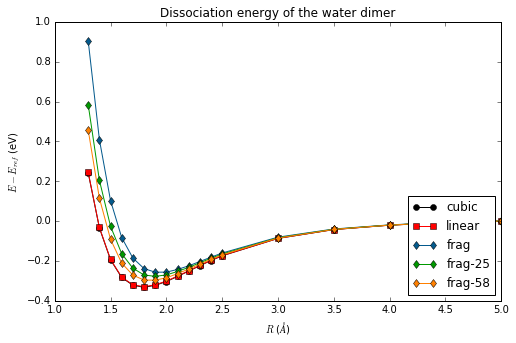

In [31]:
import matplotlib.pyplot as plt
# Lists of markers and colors (for matplotlib)
colors = ['#74a9cf', '#2b8cbe', '#045a8d', '#009900', '#FF8000']
colors = ['#000000', '#ff0000', '#045a8d', '#009900', '#FF8000']
markers = ['o','s','d','d','d']

plt.figure(figsize=(8,5))
# Plot with matplotlib
for i, data in enumerate(curves):
    plt.plot(data['distances'], data['energies'], marker=markers[i], 
             ls='-', label=data['legend'], color=colors[i])
#plt.ylim([-0.4, 0.5])
plt.xlim([1.0, 5.0])
plt.xlabel('$R$ ($\AA$)')
plt.ylabel('$E-E_{ref}$ (eV)')
plt.title('Dissociation energy of the water dimer')
plt.legend(loc=4)
plt.show()

<img src="http://bigdft.org/images/b/b1/H2o_binding.png">

To avoid running all calculation, we create two archive tar file:
* one containing all logs _log-dimer*_
* another one containing all data for the templates (_log-h2o*_ and mainly _data-h2o*_)

In [34]:
#First archive file (log to analyse)
if not os.path.exists(tarname):
    import tarfile
    tar = tarfile.open(tarname,"w:bz2")
    for name in glob.glob("log-dimer*.yaml")+glob.glob("log-h2o*.yaml"):
        tar.add(name)
    tar.close()
    print "Creation of a tar file with all log files: %s" % tarname
else:
    print "No creation of tarfile %s because it already exists!" % tarname

#Second archive file (template data)
if not os.path.exists(tartemplate):
    import tarfile
    tar = tarfile.open(tartemplate,"w:bz2")
    for name in glob.glob("data-h2o*")+glob.glob("h2o*.xyz"):
        tar.add(name)
    tar.close()
    print "Creation of a tar file with all log files: %s" % tartemplate
else:
    print "No creation of tarfile %s because it already exists!" % tartemplate

Creation of a tar file with all log files: log-h2o-dissociation.tgz
Creation of a tar file with all log files: h2o-templates.tgz
